# In Depth: Gaussian Mixture Models
K-Means is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application. The nonprobabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations. Here we will look at Gaussian mixture models, which can be viewed as an extension of the ideas behind k-means, but also can be powerful beyond clustering.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of k-Means
Given simple, well-separated data, k-means finds suitable clustering results. For example, if we have simple blobs of data, the k-means algorithm can quickly label those clusters in a way that closely matches what we can do by eye.

In [2]:
# generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

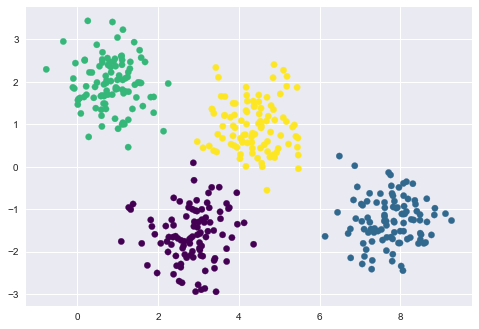

In [3]:
# Plot the data with k-means labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

We might expect that the clustering assignment for some points is more certain than others; for example, there appears to be very slight overlap between the purple and yellow clusters, such that we might not have complete confidence in the cluster assignment of points between them. Unfortunately, k-means has no model of probability or uncertainty of cluster assignments. To do this, we must generalize the model.

One way to think about k-means is that is places a circle (or hyper-sphere in higher dimensions) at the center of each cluster, with a radius defined by the most distant point in the cluster. The radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. Let's visualize this:

In [6]:
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    
    # plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.9, zorder=1))

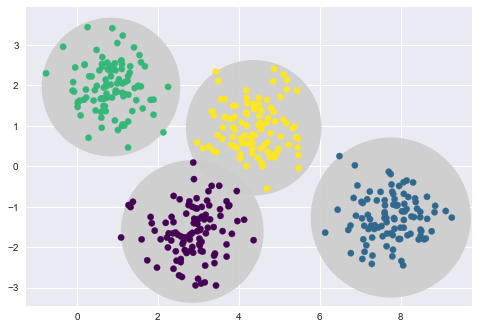

In [7]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

k-Means cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. Here as an example of this becoming a problem:

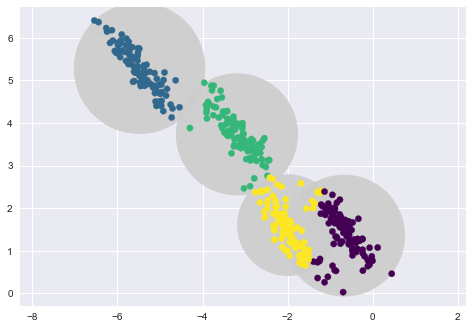

In [8]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters = 4, random_state=0)
plot_kmeans(kmeans, X_stretched)

These transformed clusters are obviously noncircular, and circular clusters would be a poor fit. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circulr clusters. The result is a mixing of cluster assignments with overlapping circles.

The lack of flexibility in cluster shape and lack of probabilistic cluster assignments in k-means suggests it may not perform very well in many datasets (especially low-dimensional). One might address these weaknesses by generalizing the k-means model: for example, you could...
 - Measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than just focusing on the closest.
 - Allow the cluster boundaries to be ellipses rather than circles to account for noncircular clusters.
 
It turns out, these are two essential components of Gaussian mixture models.

## Generalizing E-M: Gaussian Mixture Models
A ***Gaussian mixture model (GMM)*** attempts to find a mixture of multidimensional Gaussian probability distributions that best model any input dataset. At its simplest, GMMs can be used to find clusters similar to k-means:

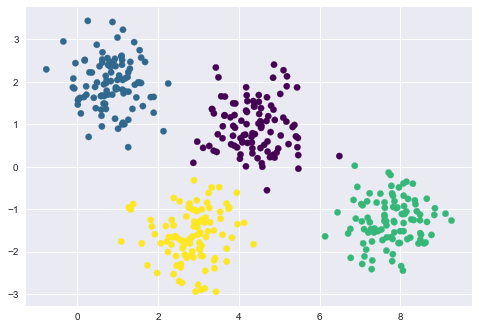

In [10]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis');

In [11]:
# GMM can also find probabilistic cluster assignments for different points!
probs = gmm.predict_proba(X)
print probs[:5].round(3)

[[ 0.537  0.     0.463  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.     0.     1.   ]
 [ 1.     0.     0.     0.   ]
 [ 0.     0.     0.     1.   ]]


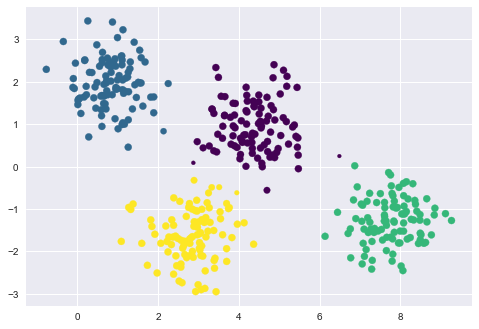

In [14]:
# visualize by making size of each point proportional to uncertainty
size = 50 * probs.max(1) ** 2 # square emphasizes differences
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis', s=size);

Under the hood, GMM is very similar to k-means: it uses an expectation-maximization approach that qualitatively does the following:
 1. Choose starting guess for location and shape
 2. Repeat until converged:
     a. E-step: for each point, find weights encoding the probability of membership in each cluster
     b. M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights
     
This results in clusters being associated with a smooth Gaussian model instead of a hard-edged sphere. Just like k-means, this approach can sometimes miss the global optimal solution, so multiple randomizations are used.

Here we will create a function to visualize the locations and shapes of the GMM clusters:

In [15]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the ellipse
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [18]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:,0], X[:,1], s=40, zorder = 2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

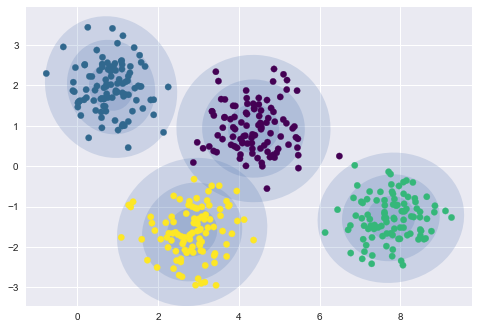

In [19]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

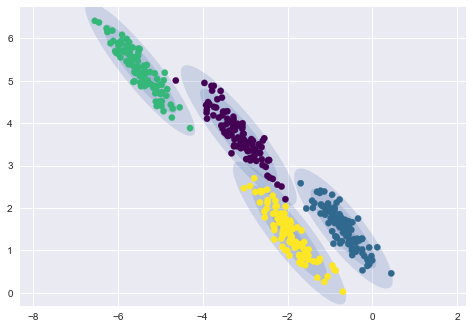

In [20]:
# Use GMM to fit stretched dataset
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

#### Choosing the covariance type
**`covariance_type`** controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem. The default **`covariance_type="diag"`**, which means the size of the cluster along each dimension can be set independently with the resulting ellipse constrained to align with the axes. A simpler, faster model is **`covariance_type="spherical"`**, which contrains the shape of the cluster such that all dimensions are equal (similar, but not entirely equivalent to k-means). A more complicated and computationally expensive model is to use **`covariance_type="full"`**, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

![covariance](images/covariance.png)

## GMM as Density Estimation
Though GMM is often categorized as a clustering algorithm, it is fundamentally an algorithm for ***density estimation***. The result of a GMM fit to some data is a generative probabilistic model describing the distribution of the data, instead of a clustering model.

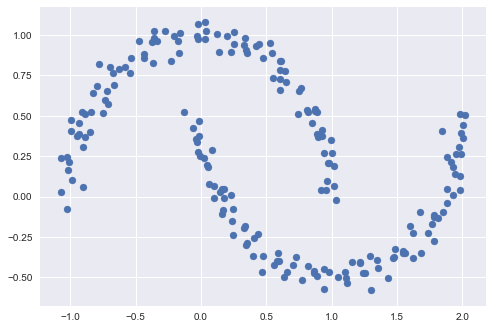

In [22]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:,0], Xmoon[:,1]);

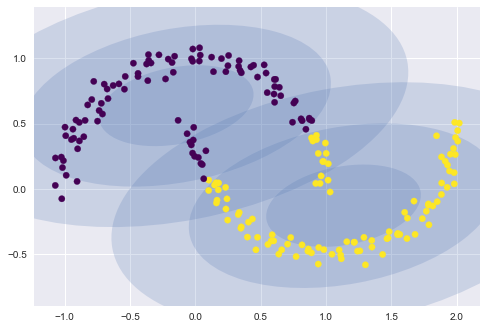

In [24]:
# fit into two-component GMM
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

This isn't particularly useful. Let's instead use many more components and ignore the cluster labels to find a fit that is much closer to the input data:

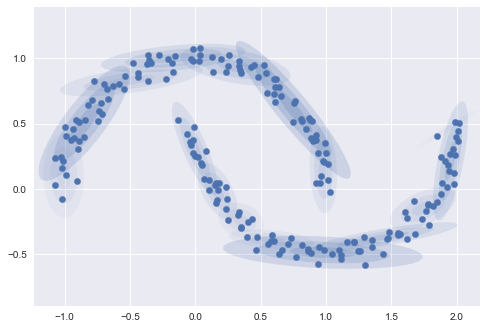

In [25]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

The mixture of 16 Gaussians serves to model the overall distribution of the input data. This is a generative model of the distribution, so it essentially gives us the recipe to generate new random data distributed similarly to our input.

#### How many components?
Because GMM is a generative model, it gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid overfitting. Another means of correcting for overfitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC).

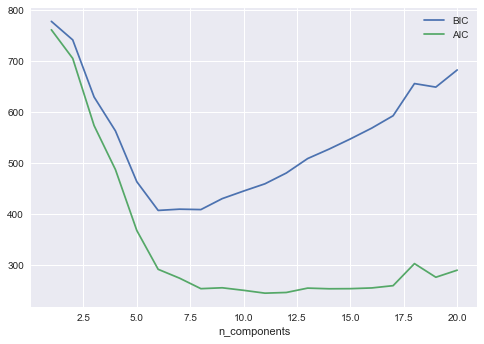

In [48]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The AIC tells us that our choice of 16 components was probably too many: around 8-12 would have been a better choice. As is typical with this sort of problem, the BIC recommends a simpler model.

**This choice of number of components measures how well GMM works as a density estimator, not as a clustering algorithm.**

## Example: GMM for Generating New Data

In [49]:
# use GMM to generate more handwritten digits
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

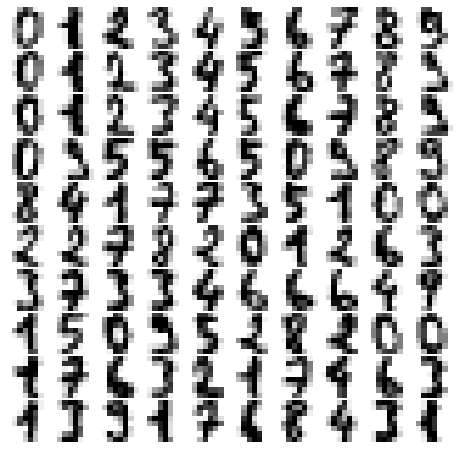

In [51]:
# plot first 100 digits
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8,8), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8,8), cmap='binary')
        im.set_clim(0,16)

plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more. GMMs can have difficulty convergin in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.

In [52]:
from sklearn.decomposition import PCA

In [53]:
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

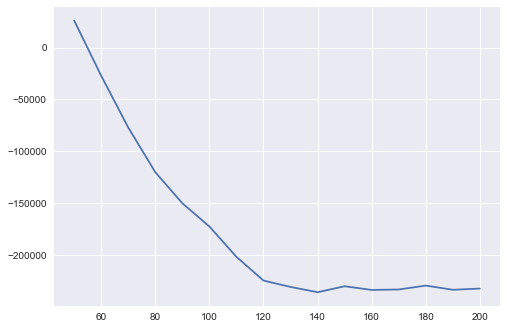

In [54]:
# result is 41 dimensions == reduction of 1/3 with no info lost
# use AIC to determine number of components
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

It looks like 110 components minimizes the AIC, so we will use this model. Now time to fit the data and confirm convergence:

In [75]:
from sklearn.mixture import GMM
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)
print gmm.converged_

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Volumes/RobStorage/anaconda2/lib/python2.7/site-packag

True


In [76]:
data_new = gmm.sample(100, random_state=0)
data_new.shape

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function sample_gaussian is deprecated; The function sample_gaussian is deprecated in 0.18 and will be removed in 0.20. Use numpy.random.multivariate_normal instead.
  warnings.warn(msg, category=DeprecationWarning)
/Volumes/RobStorage

(100, 41)

In [77]:
digits_new = pca.inverse_transform(data_new)

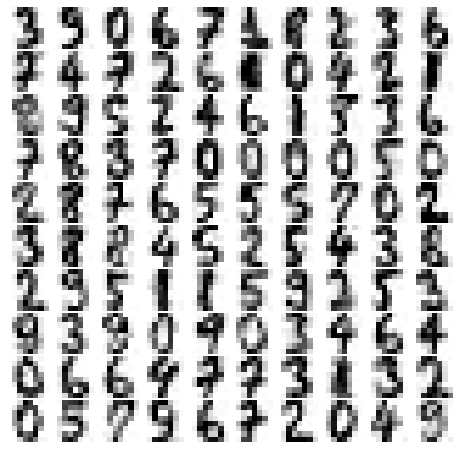

In [78]:
plot_digits(digits_new)

Given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data. These are "handwritten digits" that do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.